In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
columns = pd.read_csv("/content/drive/MyDrive/Walmart_MLE/census-income.columns")
column_names = columns.values.tolist()
column_name_list = [item for sublist in column_names for item in sublist]


In [32]:
data = pd.read_csv("/content/drive/MyDrive/Walmart_MLE/census-income.data", names=column_name_list)

#Descriptive Stats

In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
detailed industry recode,199523.0,15.352320,18.067129,0.00,0.000,0.00,33.00,51.0
detailed occupation recode,199523.0,11.306556,14.454204,0.00,0.000,0.00,26.00,46.0
wage per hour,199523.0,55.426908,274.896454,0.00,0.000,0.00,0.00,9999.0
capital gains,199523.0,434.718990,4697.531280,0.00,0.000,0.00,0.00,99999.0
capital losses,199523.0,37.313788,271.896428,0.00,0.000,0.00,0.00,4608.0
dividends from stocks,199523.0,197.529533,1984.163658,0.00,0.000,0.00,0.00,99999.0
instance weight,199523.0,1740.380269,993.768156,37.87,1061.615,1618.31,2188.61,18656.3
num persons worked for employer,199523.0,1.956180,2.365126,0.00,0.000,1.00,4.00,6.0
own business or self employed,199523.0,0.175438,0.553694,0.00,0.000,0.00,0.00,2.0
veterans benefits,199523.0,1.514833,0.851473,0.00,2.000,2.00,2.00,2.0


#Data Cleaning

In [34]:
data[data== '?'] = np.nan
data_new = data.dropna(axis=0)
data_new = data_new.drop(['major industry code','major occupation code'], axis=1)
data_new['label'].replace({'- 50000.':0, '50000+.':1}, inplace=True)

In [35]:
pd.set_option('display.max_columns', None)
data_new.head()

,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
9,Not in universe,0,0,Children,0,Not in universe,Never married,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
10,Not in universe,0,0,Children,0,Not in universe,Never married,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,5178,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,1535.86,Nonmover,Nonmover,Nonmover,Yes,Not in universe,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,1146.79,Nonmover,Nonmover,Nonmover,Yes,Not in universe,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0


#Feature Engineering

In [36]:
def cross_tab(obs1=[]):
    observed=pd.crosstab(obs1,data_new['label'])
    val=stats.chi2_contingency(observed)
    return(val[1])

category=data_new.columns[data_new.dtypes!=object].tolist()

alpha=0.01
count=0
features=[]
for i in category:
    p_value=cross_tab(data_new[i])
    if p_value<=alpha:
        count+=1
        features.append(i)
features

['detailed industry recode',
 'detailed occupation recode',
 'wage per hour',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'num persons worked for employer',
 'own business or self employed',
 'veterans benefits',
 'weeks worked in year',
 'label']

In [37]:
# columns_to_scale = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'veterans benefits', 'weeks worked in year']
# mms = MinMaxScaler()
# min_max_scaled_columns = mms.fit_transform(data_new[columns_to_scale])


In [38]:
data_new['education'].value_counts().keys()

Index(['High school graduate', 'Children', 'Some college but no degree',
       'Bachelors degree(BA AB BS)', '7th and 8th grade', '10th grade',
       '11th grade', 'Masters degree(MA MS MEng MEd MSW MBA)', '9th grade',
       'Associates degree-occup /vocational',
       'Associates degree-academic program', '5th or 6th grade',
       '12th grade no diploma', '1st 2nd 3rd or 4th grade',
       'Prof school degree (MD DDS DVM LLB JD)', 'Doctorate degree(PhD EdD)',
       'Less than 1st grade'],
      dtype='object')

#Feature reconfiguration

In [39]:
data_new['education'] = data_new['education'].str.replace('Children', '0')
data_new['education'] = data_new['education'].str.replace('Less than 1st grade', '1')
data_new['education'] = data_new['education'].str.replace('1st 2nd 3rd or 4th grade', '1')
data_new['education'] = data_new['education'].str.replace('5th or 6th grade', '1')
data_new['education'] = data_new['education'].str.replace('7th and 8th grade', '1')
data_new['education'] = data_new['education'].str.replace('9th grade', '1')
data_new['education'] = data_new['education'].str.replace('10th grade', '1')
data_new['education'] = data_new['education'].str.replace('11th grade', '1')
data_new['education'] = data_new['education'].str.replace('12th grade no diploma', '1')
data_new['education'] = data_new['education'].str.replace('High school graduate', '2')
data_new['education'] = data_new['education'].str.replace('Some college but no degree', '2')
data_new['education'] = data_new['education'].str.replace('Associates degree-occup /vocational', '2')
data_new['education'] = data_new['education'].str.replace('Associates degree-academic program', '2')
data_new['education'].replace({'Bachelors degree(BA AB BS)':'3', 'Masters degree(MA MS MEng MEd MSW MBA)': '3', 'Prof school degree (MD DDS DVM LLB JD)': '3', 'Doctorate degree(PhD EdD)': '3'}, inplace=True)
# data_new['education'] = data_new['education'].str.replace('Bachelors degree(BA AB BS)', '3')
# data_new['education'] = data_new['education'].str.replace('Masters degree(MA MS MEng MEd MSW MBA)', '3')
# data_new['education'] = data_new['education'].str.replace('Prof school degree (MD DDS DVM LLB JD)', '3')
# data_new['education'] = data_new['education'].str.replace('Doctorate degree(PhD EdD)', '3')
data_new['education'] = pd.to_numeric(data_new['education'])

In [40]:
data_new['marital stat'].value_counts().keys()

Index(['Never married', 'Married-civilian spouse present', 'Divorced',
       'Widowed', 'Separated', 'Married-spouse absent',
       'Married-A F spouse present'],
      dtype='object')

In [41]:
data_new['marital stat'] = data_new['marital stat'].str.replace('Married-civilian spouse present', '1')
data_new['marital stat'] = data_new['marital stat'].str.replace('Married-spouse absent', '1')
data_new['marital stat'] = data_new['marital stat'].str.replace('Married-A F spouse present', '1')
data_new['marital stat'] = data_new['marital stat'].str.replace('Divorced', '0')
data_new['marital stat'] = data_new['marital stat'].str.replace('Separated', '0')
data_new['marital stat'] = data_new['marital stat'].str.replace('Widowed', '0')
data_new['marital stat'] = data_new['marital stat'].str.replace('Never married', '0')
data_new['marital stat'] = pd.to_numeric(data_new['marital stat'])

In [42]:
data_new['race'].value_counts()

White                          80351
Black                           9694
Asian or Pacific Islander       2215
Other                           1127
Amer Indian Aleut or Eskimo     1075
Name: race, dtype: int64

In [43]:
data_new['sex'].value_counts()

Female    49150
Male      45312
Name: sex, dtype: int64

In [44]:
data_new['sex'] = data_new['sex'].str.replace('Female', '0')
data_new['sex'] = data_new['sex'].str.replace('Male', '1')
data_new['sex'] = pd.to_numeric(data_new['sex'])

#Feature Reduction/Pruning

In [45]:
data_new.drop(['enroll in edu inst last wk', 'hispanic origin', 'reason for unemployment', 'migration code-change in msa',	'migration code-change in reg',	'migration code-move within reg',	'family members under 18', 'instance weight',\
               'live in this house 1 year ago',	'migration prev res in sunbelt', "fill inc questionnaire for veteran's admin", 'full or part time employment stat', 'region of previous residence', 'detailed household and family stat',\
               'country of birth father', 'country of birth mother', 'country of birth self','own business or self employed',	'veterans benefits',	'weeks worked in year',	'year','capital gains', 'capital losses',	'dividends from stocks',\
               'wage per hour', 'member of a labor union'], axis=1, inplace=True)

In [46]:
data_new.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship,label
58,Self-employed-not incorporated,4,34,2,0,White,1,Head of household,Arkansas,Householder,1,Native- Born in the United States,0
9,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0
10,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0
42,Private,34,3,3,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0
34,Private,4,37,2,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0


In [47]:
data_new['tax filer stat'].value_counts()


Nonfiler                        35827
Joint both under 65             32074
Single                          17462
Joint both 65+                   3807
Head of household                3533
Joint one under 65 & one 65+     1759
Name: tax filer stat, dtype: int64

In [48]:
data_new.columns

Index(['class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'marital stat', 'race',
       'sex', 'tax filer stat', 'state of previous residence',
       'detailed household summary in household',
       'num persons worked for employer', 'citizenship', 'label'],
      dtype='object')

#Feature Encoding

In [49]:

categorical = ['class of worker', 'race', 'sex',
       'tax filer stat', 'state of previous residence',
       'detailed household summary in household',
        'citizenship']
data_train = data_new.copy(deep=True)
for feature in categorical:
        label = preprocessing.LabelEncoder()
        data_train[feature] = label.fit_transform(data_train[feature])
        # X_test[feature] = label.transform(X_test[feature])

In [50]:
data_train.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship,label
58,6,4,34,2,0,4,1,0,4,4,1,4,0
9,3,0,0,0,0,4,0,4,35,2,0,4,0
10,3,0,0,0,0,4,0,4,35,2,0,4,0
42,4,34,3,3,1,4,1,2,35,4,6,4,0
34,4,4,37,2,1,4,1,2,35,4,6,4,0


In [51]:
actual_label = data_train['label']
data_train.drop(['label'], axis=1, inplace=True)

In [52]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94462 entries, 58 to 65
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   class of worker                          94462 non-null  int64
 1   detailed industry recode                 94462 non-null  int64
 2   detailed occupation recode               94462 non-null  int64
 3   education                                94462 non-null  int64
 4   marital stat                             94462 non-null  int64
 5   race                                     94462 non-null  int64
 6   sex                                      94462 non-null  int64
 7   tax filer stat                           94462 non-null  int64
 8   state of previous residence              94462 non-null  int64
 9   detailed household summary in household  94462 non-null  int64
 10  num persons worked for employer          94462 non-null  int64
 11  citi

#Data Scaling

In [53]:
data_scaled = data_train.copy(deep=True)
# df_final = df1.copy()
scaler = StandardScaler()
for i in data_scaled.select_dtypes(exclude='object').columns:
    data_scaled.loc[:, i] = StandardScaler().fit_transform(np.array(data_scaled[[i]]))

# data_scaled = pd.DataFrame(scaler.fit_transform(data_new), columns = data_new.columns)
data_scaled.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship
58,2.270707,-0.627534,1.553167,0.525364,-0.870024,0.396755,1.041490,-2.328004,-4.001985,0.025790,-0.393833,0.311299
9,-0.439440,-0.849525,-0.786795,-1.459237,-0.870024,0.396755,-0.960163,0.566950,0.250920,-0.936354,-0.822475,0.311299
10,-0.439440,-0.849525,-0.786795,-1.459237,-0.870024,0.396755,-0.960163,0.566950,0.250920,-0.936354,-0.822475,0.311299
42,0.463942,1.037393,-0.580328,1.517664,1.149393,0.396755,1.041490,-0.880527,0.250920,0.025790,1.749376,0.311299
34,0.463942,-0.627534,1.759634,0.525364,1.149393,0.396755,1.041490,-0.880527,0.250920,0.025790,1.749376,0.311299


#Elbow Method

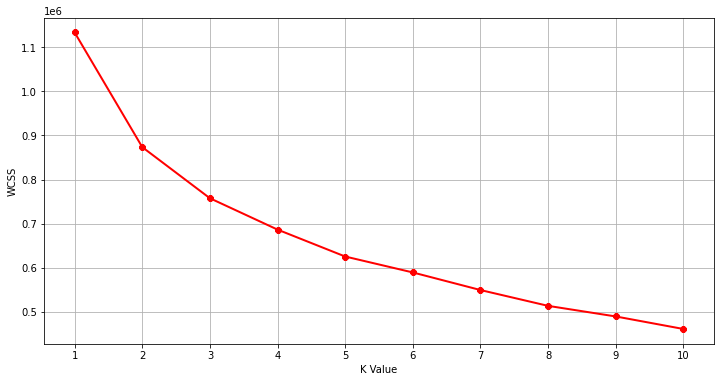

In [55]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [56]:
data_train.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship
58,6,4,34,2,0,4,1,0,4,4,1,4
9,3,0,0,0,0,4,0,4,35,2,0,4
10,3,0,0,0,0,4,0,4,35,2,0,4
42,4,34,3,3,1,4,1,2,35,4,6,4
34,4,4,37,2,1,4,1,2,35,4,6,4


#K-Means Clustering (n=3)

In [62]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
data_scaled["cluster"] = clusters

In [59]:
data_new.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship,label
58,Self-employed-not incorporated,4,34,2,0,White,1,Head of household,Arkansas,Householder,1,Native- Born in the United States,0
9,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0
10,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0
42,Private,34,3,3,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0
34,Private,4,37,2,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0


In [60]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94462 entries, 58 to 65
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   class of worker                          94462 non-null  object
 1   detailed industry recode                 94462 non-null  int64 
 2   detailed occupation recode               94462 non-null  int64 
 3   education                                94462 non-null  int64 
 4   marital stat                             94462 non-null  int64 
 5   race                                     94462 non-null  object
 6   sex                                      94462 non-null  int64 
 7   tax filer stat                           94462 non-null  object
 8   state of previous residence              94462 non-null  object
 9   detailed household summary in household  94462 non-null  object
 10  num persons worked for employer          94462 non-null  int

In [65]:
data_new["cluster"] = clusters

In [66]:
data_new.head()

,class of worker,detailed industry recode,detailed occupation recode,education,marital stat,race,sex,tax filer stat,state of previous residence,detailed household summary in household,num persons worked for employer,citizenship,label,cluster
58,Self-employed-not incorporated,4,34,2,0,White,1,Head of household,Arkansas,Householder,1,Native- Born in the United States,0,2
9,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0,1
10,Not in universe,0,0,0,0,White,0,Nonfiler,Not in universe,Child under 18 never married,0,Native- Born in the United States,0,1
42,Private,34,3,3,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0,2
34,Private,4,37,2,1,White,1,Joint both under 65,Not in universe,Householder,6,Native- Born in the United States,0,2


#Cluster description

In [69]:
data_new.loc[data_new['cluster']==0]['label'].value_counts()

0    15245
1      863
Name: label, dtype: int64

***Cluster 0 : People with >50000$ : 863***

In [70]:
data_new.loc[data_new['cluster']==1]['label'].value_counts()


0    36484
1      113
Name: label, dtype: int64

***Cluster 1 : People with >50000$ : 113***

In [71]:
data_new.loc[data_new['cluster']==2]['label'].value_counts()


0    37291
1     4466
Name: label, dtype: int64

***Cluster 2 : People with >50000$ : 4466***

#Cluster Analysis

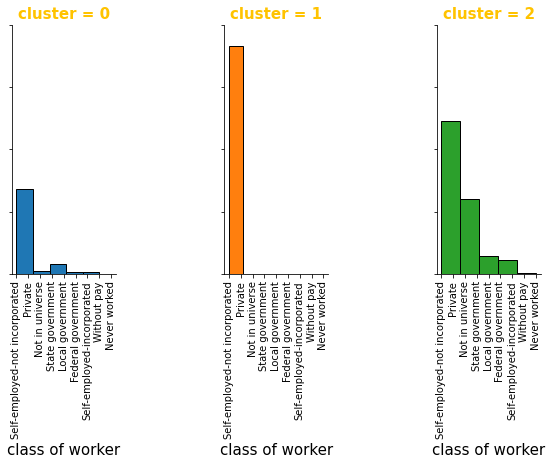

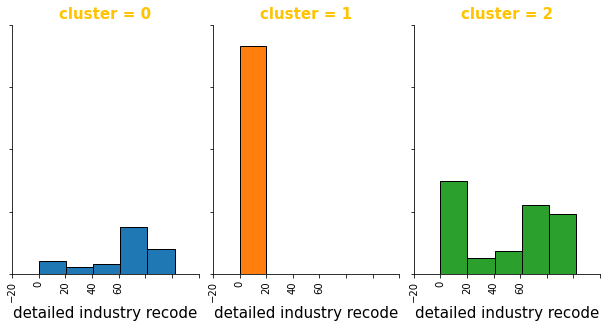

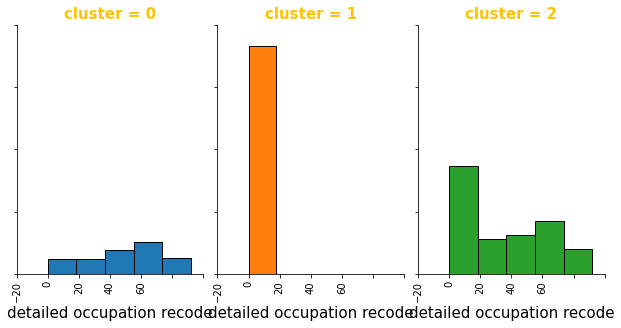

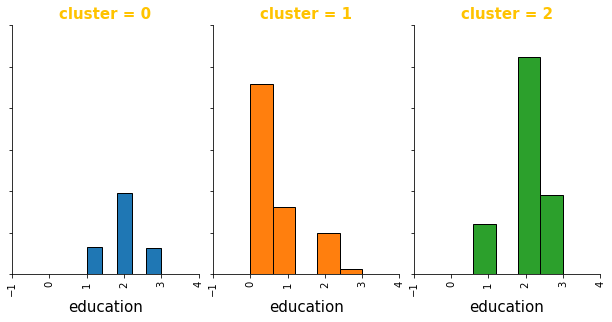

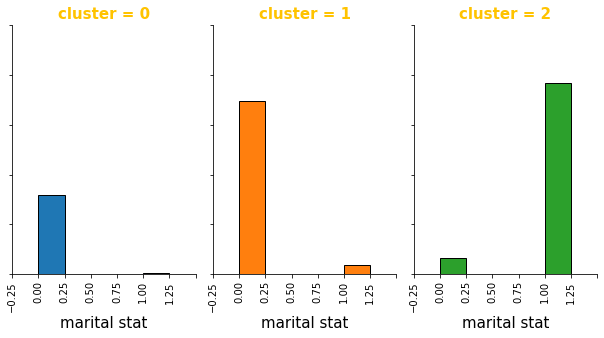

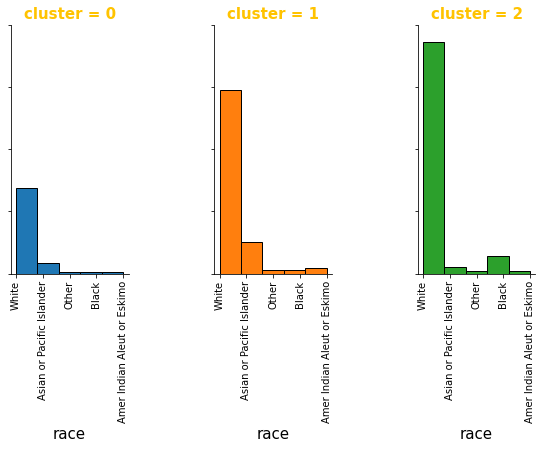

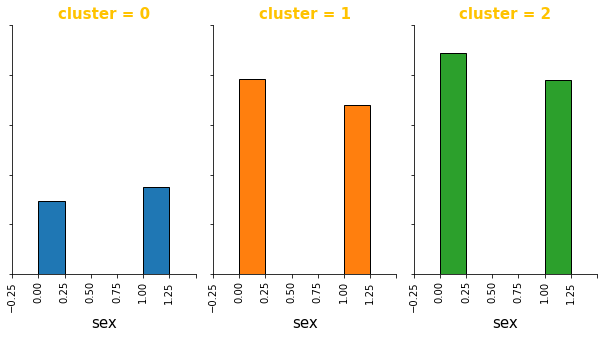

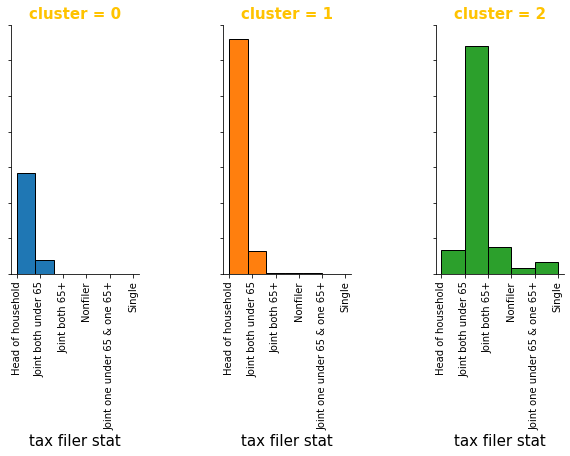

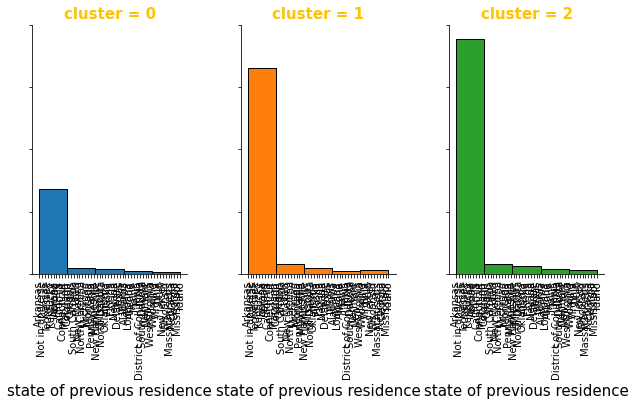

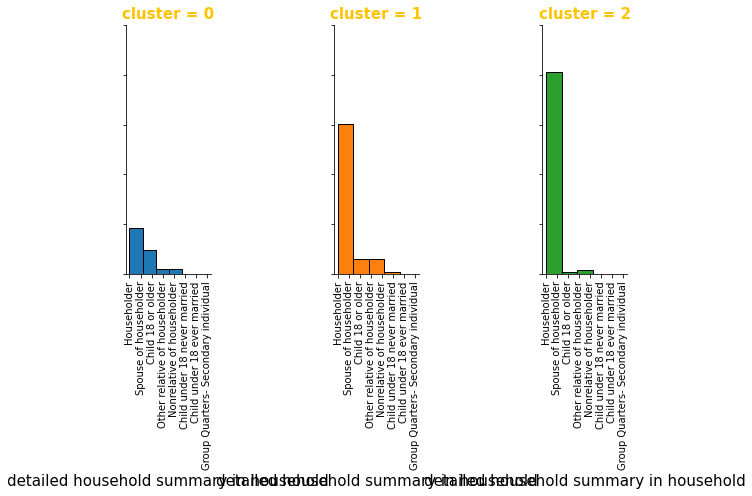

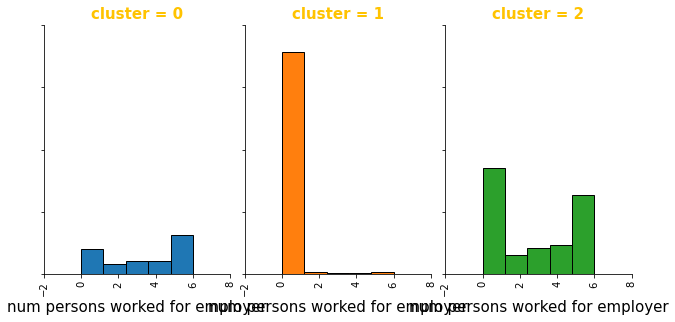

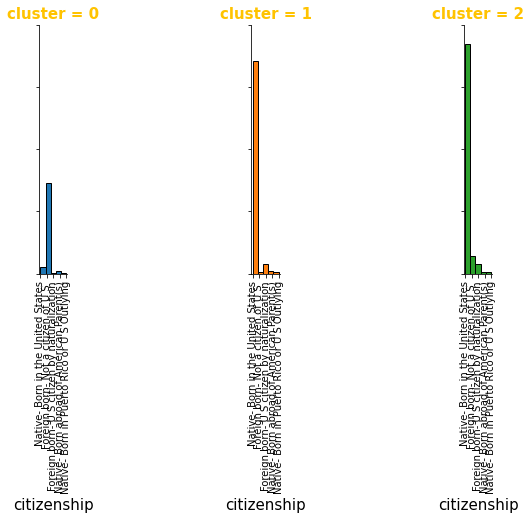

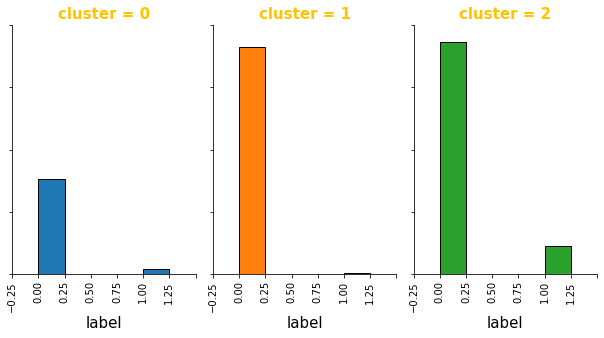

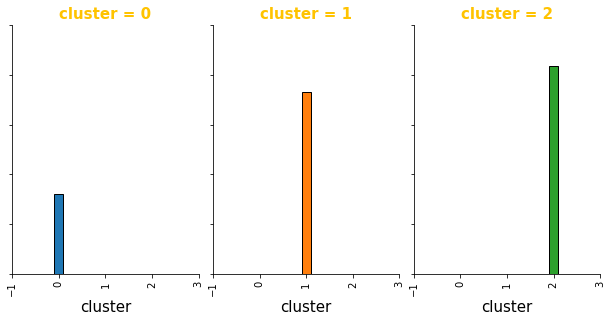

In [67]:
for i in data_new:
    g = sns.FacetGrid(data_new, col="cluster", hue="cluster")
    g.map(plt.hist, i, bins=5, ec="k")
    g.set_xticklabels(rotation=90, color='black')
    g.set_yticklabels(color='black')
    g.set_xlabels(size=15, color = 'black')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)